#Spam classification:



The goal is to identify spam messages from text data:

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


About the data:

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.



This is a binary  classification problem such that we have to train a model to predict whether the message is spam or not

In [1]:
#importing neccessary libraries:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#loading the train and testset:

df_train= pd.read_csv('spam.csv', encoding='latin-1')


print('Training data shape = {}'.format(df_train.shape))


Training data shape = (5572, 5)


In [6]:
(df_train.head())

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


##Imbalanced data as most of the messages are legit

In [7]:
df_train.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [8]:
train_data = df_train[['v1', 'v2']]


#Number of words in the sms

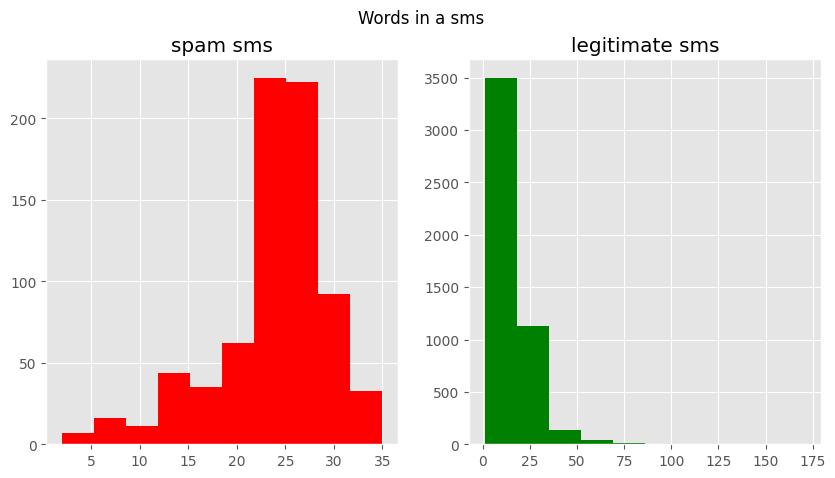

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
d_len=df_train[df_train['v1']=='spam']['v2'].str.split().map(lambda x: len(x))
ax1.hist(d_len,color='red')
ax1.set_title('spam sms')
ds_len=df_train[df_train['v1']=='ham']['v2'].str.split().map(lambda x: len(x))
ax2.hist(ds_len,color='green')
ax2.set_title('legitimate sms')
fig.suptitle('Words in a sms')
plt.show()

In [10]:
from nltk.corpus import stopwords
import re
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return  ' '.join(text)
    return ' '.join(text)

In [11]:
train_data['v2']= train_data['v2'].apply(text_cleaning)


<ipython-input-11-15f7f1ae5b7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['v2']= train_data['v2'].apply(text_cleaning)


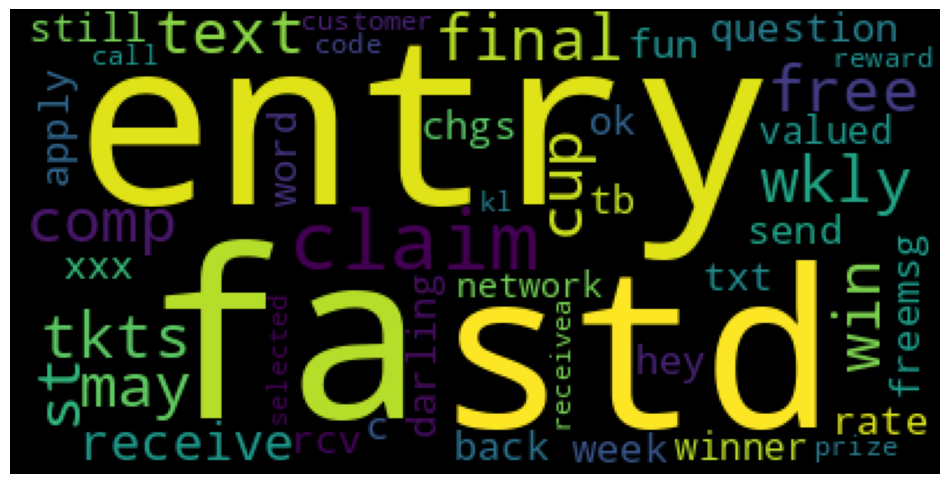

In [12]:
#creating wordcloud
def create_corpus(df2, target):
    corpus=[]

    for x in df2[df2['v1']==target]['v2'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


corpus1= create_corpus(train_data, 'spam')

from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

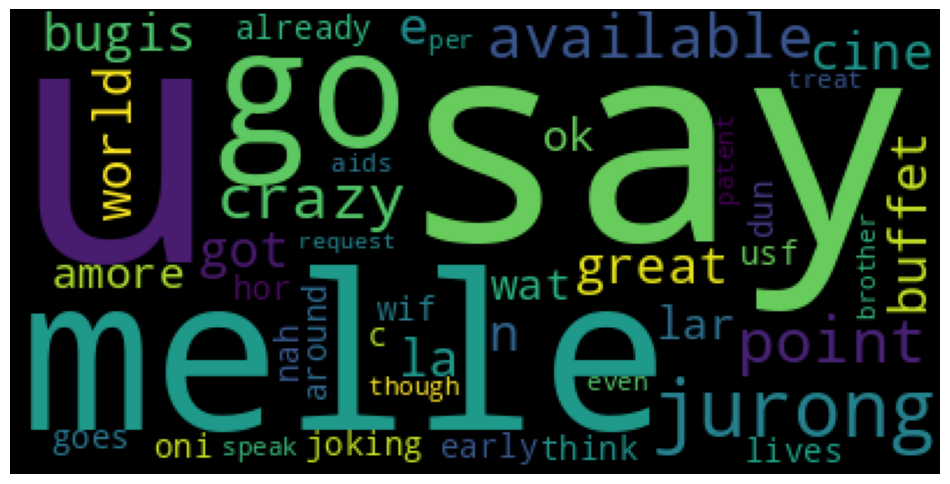

In [13]:

corpus1= create_corpus(train_data, 'ham')
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [14]:
train_data['v1'] = train_data.v1.map({'ham':0, 'spam':1})

<ipython-input-14-a623ca9d6120>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['v1'] = train_data.v1.map({'ham':0, 'spam':1})


In [25]:
train_data['v1'].value_counts()

0    4825
1     747
Name: v1, dtype: int64

In [26]:


from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy= train_test_split(train_data['v2'],train_data['v1'], test_size= 0.2, random_state=42)


In [31]:
idx=0
for val in trainy:
  if val==1:
    idx+=1

print(idx, len(trainy)-idx)

idx=0
for val in testy:
  if val==1:
    idx+=1

print(idx, len(testy)-idx)

597 3860
150 965


#Training the model

In [16]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Tokenizer to split the text and convert into numbers, we pad the sequences, to ensure we get the text of same length.

In [17]:
tokenize = Tokenizer()
tokenize.fit_on_texts(trainx.values)


X_train= tokenize.texts_to_sequences(trainx)
X_test = tokenize.texts_to_sequences(testx)

X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

## Defining the model

In [18]:
EMBEDDING_DIM = 100
unknown = len(tokenize.word_index)+1
model = Sequential()
model.add(layers.Embedding(unknown, EMBEDDING_DIM))
model.add(layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2 ))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         674600    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 791,977
Trainable params: 791,977
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [20]:
model.fit(X_train, trainy, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
35/35 [==============================] - 25s 603ms/step - loss: 0.3282 - accuracy: 0.8896
Epoch 2/5
35/35 [==============================] - 29s 824ms/step - loss: 0.0742 - accuracy: 0.9818
Epoch 3/5
35/35 [==============================] - 20s 569ms/step - loss: 0.0258 - accuracy: 0.9919
Epoch 4/5
35/35 [==============================] - 21s 611ms/step - loss: 0.0111 - accuracy: 0.9971
Epoch 5/5
35/35 [==============================] - 21s 610ms/step - loss: 0.0068 - accuracy: 0.9984


In [21]:
final_pred = model.predict(X_test)
final_pred

35/35 [==============================] - 1s 24ms/step


array([[8.8413194e-04],
       [3.8980265e-04],
       [9.8123169e-01],
       ...,
       [2.0540861e-04],
       [4.6000959e-04],
       [9.9184710e-01]], dtype=float32)

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [33]:
pred=[]
for val in final_pred:
  if val>0.5:
    pred.append(1)
  else:
    pred.append(0)

In [39]:
print(classification_report(testy, pred))
print("-"*100)
print(confusion_matrix(testy, pred))
print("-"*100)

print(accuracy_score(testy, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.88      0.94       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

----------------------------------------------------------------------------------------------------
[[965   0]
 [ 18 132]]
----------------------------------------------------------------------------------------------------
0.9838565022421525


In [43]:
vect = CountVectorizer()

In [44]:
X_train_dtm = vect.fit_transform(trainx)

In [45]:
X_test_dtm = vect.transform(testx)
X_test_dtm


<1115x6727 sparse matrix of type '<class 'numpy.int64'>'
	with 8128 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_dtm, trainy)
y_pred_class = nb.predict(X_test_dtm)

In [47]:
print(classification_report(testy, y_pred_class))
print("-"*100)
print(confusion_matrix(testy, y_pred_class))
print("-"*100)

print(accuracy_score(testy, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.94      0.91      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

----------------------------------------------------------------------------------------------------
[[957   8]
 [ 13 137]]
----------------------------------------------------------------------------------------------------
0.9811659192825112


In [48]:
vect_combined= CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2,max_df=0.5)
X_train_dtm = vect.fit_transform(trainx)
X_test_dtm = vect.transform(testx)
X_test_dtm
nb = MultinomialNB()
nb.fit(X_train_dtm, trainy)
y_pred_class = nb.predict(X_test_dtm)
print(classification_report(testy, y_pred_class))
print("-"*100)
print(confusion_matrix(testy, y_pred_class))
print("-"*100)

print(accuracy_score(testy, y_pred_class))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.94      0.91      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

----------------------------------------------------------------------------------------------------
[[957   8]
 [ 13 137]]
----------------------------------------------------------------------------------------------------
0.9811659192825112


In [49]:
from sklearn.linear_model import LogisticRegression

# 2. instantiate a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_dtm, trainy)
y_pred_class = logreg.predict(X_test_dtm)
print(classification_report(testy, y_pred_class))
print("-"*100)
print(confusion_matrix(testy, y_pred_class))
print("-"*100)

print(accuracy_score(testy, y_pred_class))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115

----------------------------------------------------------------------------------------------------
[[965   0]
 [ 27 123]]
----------------------------------------------------------------------------------------------------
0.9757847533632287


End notes:

Things to be tried, since the dataset is imbalanced, the precision , recall metrics on minority class can be tried to improved, and imbalance handling techniques can be focused on. Further, trying autoencoders can also be alternate ways to handle spam classification.
Also BERT for sequence classification can be tried to perform binary classification.